In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [2]:
root = '/content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfbc5442d0>,
      dtype=object)

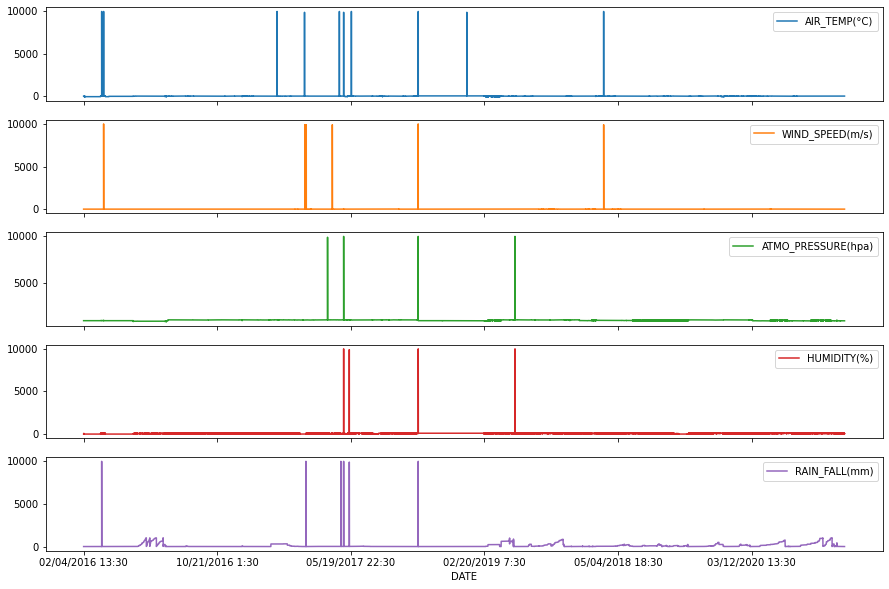

In [4]:
df = pd.read_csv(root+'west_bengal_isro.csv')
df['DATE'] = df['DATE(IST)'] + " " + df['TIME(IST)']
df.drop(columns=['@STATION_ID', 'ALTITUDE(m)', 'WIND_DIRECTION(deg)', 'SUN_SHINE(hh:mm)','BATTERY_VOLTAGE(V)','TIME(GMT)', 'DATE(GMT)', 'TIME(IST)', 'DATE(IST)', 'LATITUDE', 'LONGITUDE'])
df.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True,figsize=(15, 10))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfbd27ed90>,
      dtype=object)

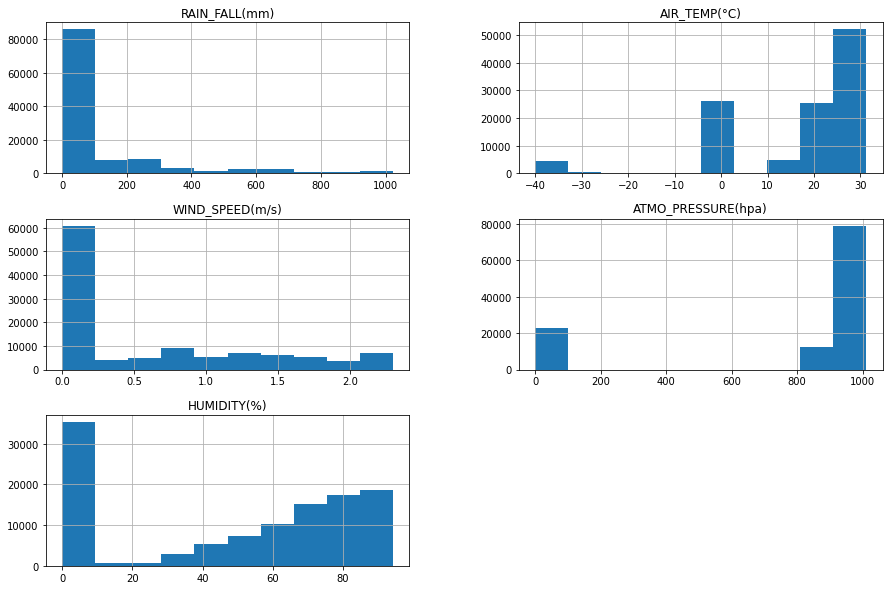

In [5]:
df_input=df[['RAIN_FALL(mm)','AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)']]
for i in df_input.columns:
  if(i == 'RAIN_FALL(mm)'):
    a = df_input[i] > 2000
    df_input[i][a] = 0
  elif (i == 'DATE'):
    continue
  else:
    a = df_input[i].quantile(0.80)
    b = df_input[i] > a
    df_input[i][b] = 0
df_input.hist(figsize = (15, 10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfbc0ebf90>,
      dtype=object)

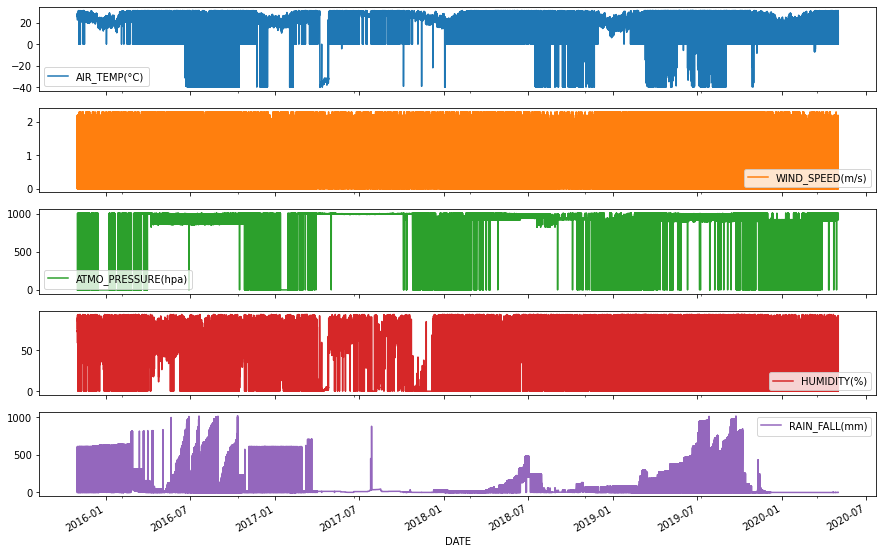

In [6]:
df_input['DATE'] = pd.to_datetime(df['DATE'], format="%m/%d/%Y %H:%M")
df_input.set_index('DATE')[['AIR_TEMP(°C)', 'WIND_SPEED(m/s)','ATMO_PRESSURE(hpa)', 'HUMIDITY(%)', 'RAIN_FALL(mm)']].plot(subplots=True, figsize=(15, 10))

In [7]:
df_input.to_csv(root+'corrected/west_bengal.csv', header=True, index=False)
df_input.describe()

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
count,113899.000000,113899.000000,113899.000000,113899.000000,113899.000000
mean,98.056954,16.454524,0.592694,766.725103,48.380487
std,190.582156,16.060579,0.747329,384.444150,35.407244
min,0.000000,-40.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,900.800000,0.100000
50%,8.000000,23.000000,0.000000,925.000000,61.000000
75%,97.000000,27.900000,1.200000,999.800000,79.700000
max,1023.000000,31.200000,2.300000,1010.400000,94.200000


## Data split
Split the data into training and test set 

In [8]:
datelist = df_input['DATE']
print(datelist)
df_input = df_input.drop('DATE', 1)
training_set = df_input

0        2016-02-04 13:30:00
1        2016-02-04 14:30:00
2        2016-02-04 15:30:00
3        2016-02-04 16:30:00
4        2016-02-04 17:30:00
                 ...        
113894   2020-04-25 12:30:00
113895   2020-04-26 08:30:00
113896   2020-04-26 09:30:00
113897   2020-04-26 12:30:00
113898   2020-04-27 11:30:00
Name: DATE, Length: 113899, dtype: datetime64[ns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
training_set

,RAIN_FALL(mm),AIR_TEMP(°C),WIND_SPEED(m/s),ATMO_PRESSURE(hpa),HUMIDITY(%)
0,0.0,0.0,0.0,925.0,28.0
1,0.0,0.0,0.0,925.0,27.0
2,0.0,0.0,0.0,925.0,27.0
3,0.0,0.0,0.0,925.0,27.0
4,0.0,30.7,0.0,925.0,28.0
...,...,...,...,...,...
113894,2.0,29.8,0.0,905.5,57.1
113895,1.0,27.4,0.0,908.3,71.7
113896,1.0,28.4,0.0,908.8,70.4
113897,1.0,27.9,0.6,908.0,71.0


In [10]:
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set.iloc[:, 1:2])

array([[-1.02453317],
       [-1.02453317],
       [-1.02453317],
       ...,
       [ 0.74377945],
       [ 0.71264718],
       [ 0.77491171]])

In [11]:
training_set_scaled

array([[-0.51451503, -1.02453317, -0.79308734,  0.41169983, -0.57560471],
       [-0.51451503, -1.02453317, -0.79308734,  0.41169983, -0.60384764],
       [-0.51451503, -1.02453317, -0.79308734,  0.41169983, -0.60384764],
       ...,
       [-0.50926793,  0.74377945, -0.79308734,  0.36956089,  0.6218956 ],
       [-0.50926793,  0.71264718,  0.00977565,  0.36747995,  0.63884136],
       [-0.50926793,  0.77491171, -0.79308734,  0.37216206,  0.41289791]])

In [13]:
X_train = []
y_train = []

n_future = 90   # Number of observations we want top predict into the future
n_past = 60     # Number of past observations we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 1])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (113750, 60, 5).
y_train shape == (113750, 1).


In [14]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, df_input.shape[1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01,), loss='mean_squared_error')

In [15]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath= root+'1_week5_lstm_isro.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=12, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/12
355/356 [============================>.] - ETA: 0s - loss: 0.4231
Epoch 1: val_loss improved from inf to 0.48880, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/1_week5_lstm_isro.h5
356/356 [==============================] - 21s 39ms/step - loss: 0.4232 - val_loss: 0.4888 - lr: 0.0100
Epoch 2/12
355/356 [============================>.] - ETA: 0s - loss: 0.4010
Epoch 2: val_loss improved from 0.48880 to 0.47528, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/1_week5_lstm_isro.h5
356/356 [==============================] - 13s 35ms/step - loss: 0.4014 - val_loss: 0.4753 - lr: 0.0100
Epoch 3/12
356/356 [==============================] - ETA: 0s - loss: 0.4075
Epoch 3: val_loss improved from 0.47528 to 0.46353, saving model to /content/drive/MyDrive/Semester 5 - Project REAPS/Documents/6 sem/Code/Data/1_week5_lstm_isro.h5
356/356 [==============================] - 12s 35ms/step - loss: 0.407

In [16]:
datelist_future = pd.date_range(datelist.iloc[-1], periods=15000, freq='3h').tolist()
predictions_future = model.predict(X_train[-15000:])

predictions_train = model.predict(X_train[n_past:])

In [21]:
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Air Temp (°C)']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Air Temp (°C)']).set_index(pd.Series(datelist[2 * n_past + n_future -1:]))
PREDICTION_TRAIN.head(3)

,Air Temp (°C)
DATE,
2016-07-05 14:30:00,-30.970961
2016-07-05 15:30:00,-30.998308
2016-07-05 16:30:00,-31.024393


In [22]:
df_input['DATE'] = datelist

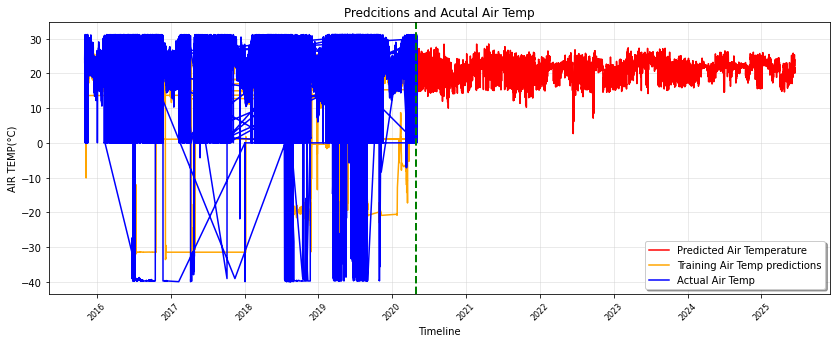

In [23]:
plt.rcParams['figure.figsize'] = 14, 5

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Air Temp (°C)'], color='r', label='Predicted Air Temperature')
plt.plot(PREDICTION_TRAIN.iloc[0:].index, PREDICTION_TRAIN.iloc[0:]['Air Temp (°C)'], color='orange', label='Training Air Temp predictions')
plt.plot(df_input.iloc[0:]['DATE'], df_input.iloc[0:]['AIR_TEMP(°C)'], color='b', label='Actual Air Temp')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Air Temp', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('AIR TEMP(°C)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()